# Example for the reference resistance calculation

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from harps import salinity_harps as sh

Populating the interactive namespace from numpy and matplotlib


### read in data from file and select module and variable

In [2]:
data = sh.read_harp_file('test_data.dat')
data = data.sel(module=0)
resistance = data['r10']

/home/mpim/m300660/Programs/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


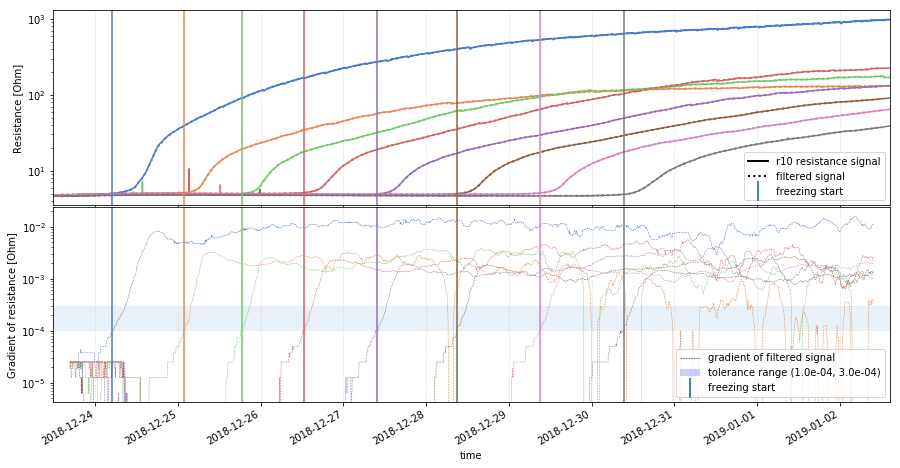

In [3]:
import seaborn as sns
colors = sns.color_palette("muted", 8)
#sns.palplot(colors, size=.5)

# smoothen the signal
resistance_smooth = sh.median(resistance)
# compute gradient of that smoothened signal
resistance_grad = sh.median(sh.grad(resistance_smooth, 20))

# find values that are in a certain range around 0.5 and mask others
tolerance = (1e-4, 3e-4)
grad_tol = np.where(np.logical_and(resistance_grad > tolerance[0], resistance_grad < tolerance[1]), resistance_grad, np.nan)
# set all those values to common value
grad_tol[~np.isnan(grad_tol)] = 1

# now find the first occurrence in that array which is not NAN
#ym = np.abs(y-0.5).argmin()
freezing_starts = np.nanargmin(grad_tol, axis=0).squeeze()

plt.figure(figsize=(15,8))
ax = plt.gca()
ax0 = plt.subplot(211)
ax1 = plt.subplot(212)

# plot resistance
resistance.squeeze().to_pandas().plot(logy=True, color=colors, ax=ax0)
resistance_smooth.squeeze().to_pandas().plot(color=colors, ax=ax0, ls=':', lw=2)

# plot gradient
resistance_grad.squeeze().to_pandas().plot(logy=True, color=colors, ax=ax1, ls='--', lw=.5)
#da_grad_cut.squeeze().to_pandas().plot(color=colors, ax=ax1, ls='--', lw=2, marker='', fillstyle='none', markevery=150)

ax1.axhspan(*tolerance, alpha=.1)

for i, c in enumerate(freezing_starts):
    ax0.axvline(x=resistance.time.values[c], color=colors[i])
    ax1.axvline(x=resistance.time.values[c], color=colors[i])

    
    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

ax0_legend_elements = [Line2D([0], [0], color='k', lw=2, label='r10 resistance signal'),
                       Line2D([0], [0], color='k', ls=':', lw=2, label='filtered signal'),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]

ax1_legend_elements = [Line2D([0], [0], color='k', ls='--', lw=.5, label='gradient of filtered signal'),
                       #Line2D([0], [0], color='k', ls='--', lw=2, marker='', fillstyle='none', label='gradient of filtered signal < 1e-3'),
                       Patch(facecolor='b', alpha=.2, label='tolerance range ({:.1e}, {:.1e})'.format(*tolerance)),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]

ax0.tick_params(labelbottom=False)
ax0.set_xlabel(None)
ax0.set_ylabel('Resistance [Ohm]')
ax1.set_ylabel('Gradient of resistance [Ohm]')
plt.subplots_adjust(hspace=0.01)
for axis in plt.gcf().axes:
    axis.grid(axis='x', alpha=.2)

ax0.legend(handles=ax0_legend_elements, loc='lower right')
ax1.legend(handles=ax1_legend_elements, loc='lower right')


In [4]:
r0s = sh.calc_reference_resistance(data, 'r10', kind='butterworth', tolerance=(1e-4, 3e-4))
T_freeze = data['temperature'].sel(time=r0s.coords['time'])


In [5]:
ds = sh.read_harp_data(file='test_data.dat', module=0)
ds

<xarray.Dataset>
Dimensions:          (time: 4998, wire_pair: 8)
Coordinates:
  * time             (time) datetime64[ns] 2018-12-23T11:41:11 ... 2019-01-02T14:34:10
    module           int64 0
  * wire_pair        (wire_pair) int64 0 1 2 3 4 5 6 7
Data variables:
    i10              (wire_pair, time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    i6               (wire_pair, time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    r10              (wire_pair, time) float64 4.741 4.711 4.737 ... 38.72 38.76
    r6               (wire_pair, time) float64 7.886 7.888 7.877 ... 42.56 42.59
    t_case           (wire_pair, time) float64 -16.33 -16.3 ... -16.34 -16.31
    temperature      (wire_pair, time) float64 0.5 0.562 0.438 ... -1.875 -1.938
    brine salinity   (wire_pair, time) float64 nan nan nan ... 36.56 36.56 37.73
    bulk salinity    (wire_pair, time) float64 nan nan nan ... 4.459 4.455 4.593
    liquid fraction  (wire_pair, time) float64 nan nan nan ... 0.1219 0.1217
    solid fractio

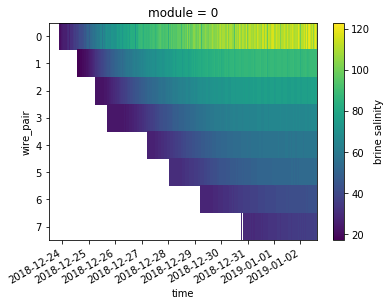

In [6]:
ds['brine salinity'].plot(yincrease=False)